## Import librairies

In [201]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer
from sklearn.model_selection import GridSearchCV

pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [202]:
# Aide sur la fonction
load_digits?

Signature: load_digits(*, n_class=10, return_X_y=False, as_frame=False)
Docstring:
Load and return the digits dataset (classification).

Each datapoint is a 8x8 image of a digit.

=================   ==============
Classes                         10
Samples per class             ~180
Samples total                 1797
Dimensionality                  64
Features             integers 0-16
=================   ==============

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

Read more in the :ref:`User Guide <digits_dataset>`.

Parameters
----------
n_class : int, default=10
    The number of classes to return. Between 0 and 10.

return_X_y : bool, default=False
    If True, returns ``(data, target)`` instead of a Bunch object.
    See below for more information about the `data` and `target` object.

    .. versionadded:: 0.18

as_frame : bool, default=False
    If True, the data is a

In [203]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [204]:
data.head(20)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
5,0.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,16.0,16.0,14.0,0.0,0.0,0.0,0.0,13.0,16.0,15.0,10.0,1.0,0.0,0.0,0.0,11.0,16.0,16.0,7.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,16.0,7.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0,9.0,0.0,0.0,0.0,5.0,4.0,12.0,16.0,4.0,0.0,0.0,0.0,9.0,16.0,16.0,10.0,0.0,0.0,5
6,0.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,0.0,0.0,5.0,16.0,8.0,0.0,0.0,0.0,0.0,0.0,13.0,16.0,3.0,0.0,0.0,0.0,0.0,0.0,14.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,12.0,7.0,2.0,0.0,0.0,0.0,0.0,13.0,16.0,13.0,16.0,3.0,0.0,0.0,0.0,7.0,16.0,11.0,15.0,8.0,0.0,0.0,0.0,1.0,9.0,15.0,11.0,3.0,0.0,6
7,0.0,0.0,7.0,8.0,13.0,16.0,15.0,1.0,0.0,0.0,7.0,7.0,4.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0,8.0,13.0,1.0,0.0,0.0,4.0,8.0,8.0,15.0,15.0,6.0,0.0,0.0,2.0,11.0,15.0,15.0,4.0,0.0,0.0,0.0,0.0,0.0,16.0,5.0,0.0,0.0,0.0,0.0,0.0,9.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,5.0,0.0,0.0,0.0,0.0,7
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,12.0,14.0,14.0,12.0,0.0,0.0,0.0,0.0,9.0,10.0,0.0,15.0,4.0,0.0,0.0,0.0,3.0,16.0,12.0,14.0,2.0,0.0,0.0,0.0,4.0,16.0,16.0,2.0,0.0,0.0,0.0,3.0,16.0,8.0,10.0,13.0,2.0,0.0,0.0,1.0,15.0,1.0,3.0,16.0,8.0,0.0,0.0,0.0,11.0,16.0,15.0,11.0,1.0,0.0,8
9,0.0,0.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,16.0,16.0,13.0,0.0,0.0,0.0,3.0,16.0,12.0,10.0,14.0,0.0,0.0,0.0,1.0,16.0,1.0,12.0,15.0,0.0,0.0,0.0,0.0,13.0,16.0,9.0,15.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,9.0,11.0,0.0,0.0,0.0,0.0,0.0,9.0,15.0,4.0,0.0,0.0,0.0,9.0,12.0,13.0,3.0,0.0,0.0,9


Infos sur le dataset : Chaque X représente un pixel (une partie de l'image) et l'idée est de reconstituer l'ensemble des pixels pour retrouver l'image du chiffre. L'image est sous format 8x8. Et donc on a 64 pixels pour chaque image donc des Xi i = 0, 1, 2, ..., 63

In [205]:
data.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,10.382304,11.979410,10.279354,8.175849,1.846411,0.107958,0.002782,2.601558,9.903172,6.992766,7.097941,7.806344,1.788536,0.050083,0.001113,2.469672,9.091263,8.821369,9.927101,7.551475,2.317752,0.002226,0.0,2.339455,7.667223,9.071786,10.301614,8.744018,2.909293,0.0,0.008904,1.583751,6.881469,7.228158,7.672231,8.236505,3.456316,0.027268,0.007234,0.704508,7.506956,9.539232,9.416249,8.758486,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,5.421456,3.977543,4.782681,6.052960,3.586321,0.827915,0.062368,3.576301,5.690767,5.802662,6.175729,6.197322,3.259870,0.438597,0.033352,3.146532,6.192038,5.882936,6.152093,5.872556,3.686456,0.047140,0.0,3.480372,6.324687,6.268391,5.933490,5.870648,3.537283,0.0,0.145185,2.981816,6.537955,6.441378,6.259511,5.695527,4.330951,0.307356,0.204223,1.746153,5.644496,5.226948,5.302048,6.031154,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,9.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,4.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.000000,6.000000,3.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,12.000000,13.000000,11.000000,9.000000,0.000000,0.000000,0.000000,1.000000,12.000000,6.000000,6.000000,8.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,12.000000,7.000000,0.000000,0.000000,0.0,0.000000,8.000000,10.000000,13.000000,10.000000,1.000000,0.0,0.000000,0.000000,6.000000,7.000000,8.000000,9.000000,1.000000,0.000000,0.000000,0.000000,8.000000,10.000000,10.000000,10.000000,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.

## EDA

C:\Users\HP\AppData\Local\Temp\ipykernel_5020\3374211802.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


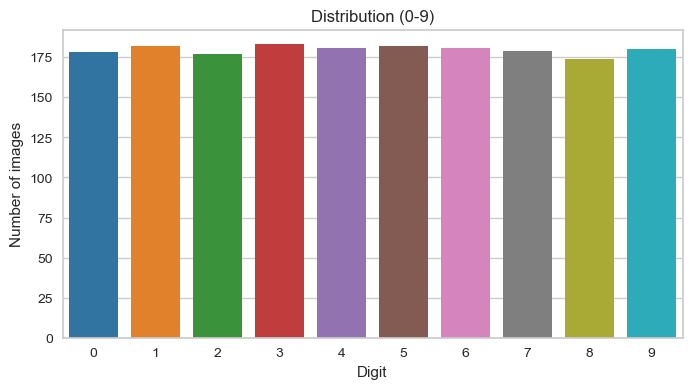

In [206]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

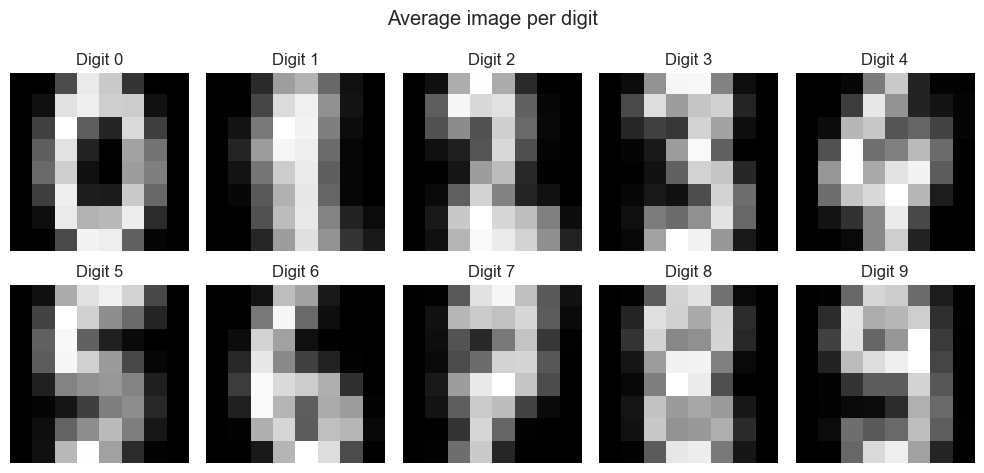

In [207]:
# mean by digit
# On ne pas calculer les 1700 images, mais on calcule la moyenne des images
# Pour chaque chiffre par exemple on prend l'image moyen (calculé à parit des vecteurs 
# des images de chaque catégories) qui permet de décrire le chiffre.
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)
# Pour chaque variable, on calcule le pixel moyenne pour les mêmes chiffres

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()
# Les résultats montrent l'image moyen pour chaque chiffre

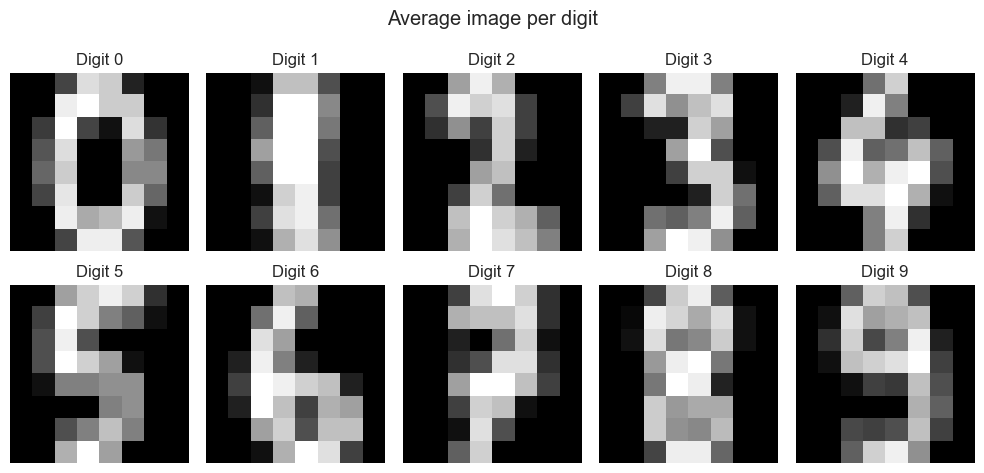

In [208]:
# median by digit
# Prendre la valeur minimum de chaque image
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].median(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()
# Les résultats montrent l'image moyen pour chaque chiffre

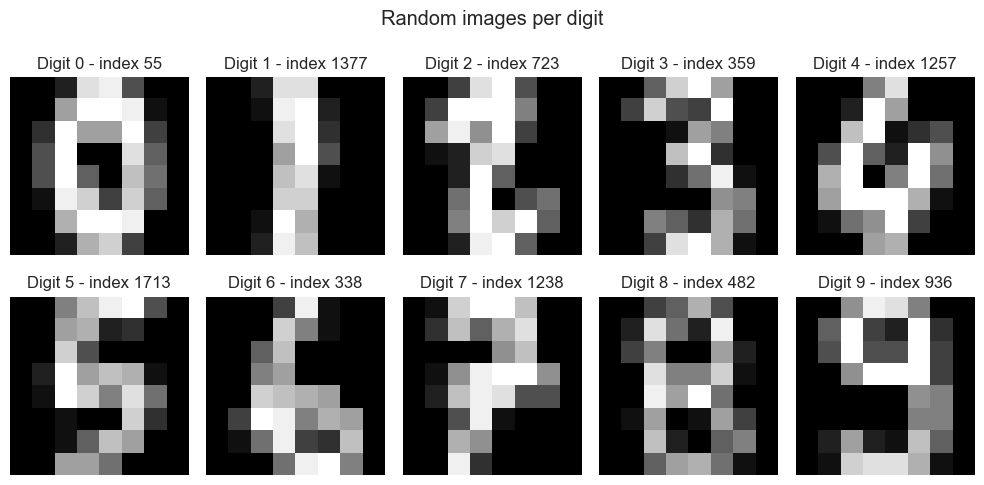

In [209]:
# On peut aussi choisir une image au hazard pour représenter chaque catégorie 
# au lieu de prendre l'image moyenne
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

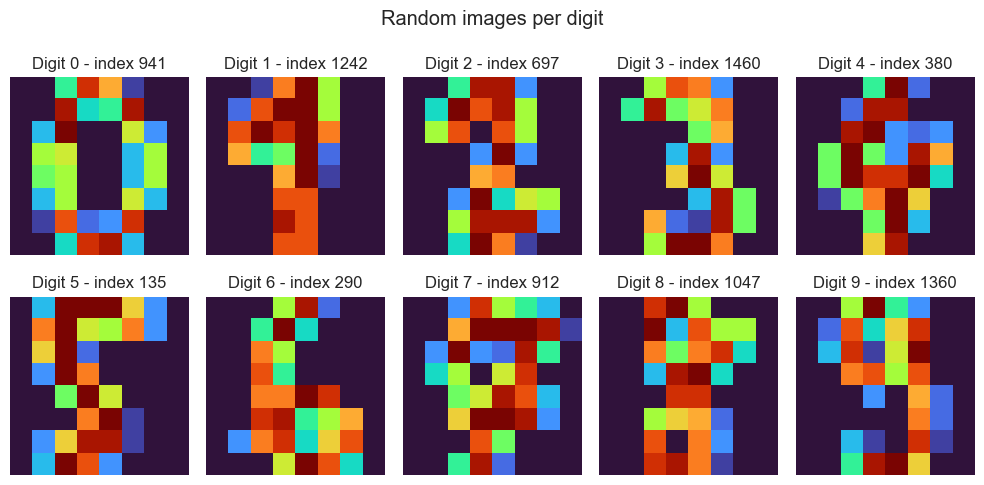

In [210]:
# Affichage des images en couleurs avec turbo : RGB
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='turbo')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [211]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=500,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return results

### Run benchmark

Globalement, les modèles avec l'ACP donne de meilleurs scores par rapport aux métriques de performance (ARI, homogeneity, completness et v-measure).

In [212]:
param_grid = {
    'n_clusters' : range(2, 15),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500]
}

#### Tuning hyperparameters and optimal number of clusters (without PCA)

In [213]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means(kmeans, name=init, data=X_pca, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params = {'init': init, 'n_init': n_init, 'max_iter': max_iter}
print("_" * 82)
print("Best hyperparameters :")
print(best_params)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.063s	1181	0.230	0.856	0.362	0.138	0.130
k-means++	0.078s	1126	0.306	0.645	0.415	0.226	0.137
k-means++	0.075s	1084	0.387	0.690	0.496	0.284	0.135
k-means++	0.094s	1043	0.483	0.728	0.581	0.378	0.143
k-means++	0.100s	1008	0.531	0.721	0.611	0.415	0.162
k-means++	0.114s	975	0.619	0.770	0.687	0.501	0.175
k-means++	0.068s	950	0.696	0.790	0.740	0.618	0.193
k-means++	0.092s	924	0.719	0.774	0.746	0.637	0.205
k-means++	0.078s	903	0.773	0.781	0.777	0.715	0.198
k-means++	0.104s	887	0.746	0.731	0.739	0.642	0.189
k-means++	0.109s	866	0.781	0.732	0.756	0.676	0.190
k-means++	0.130s	850	0.800	0.729	0.763	0.680	0.185
k-means++	0.141s	840	0.806	0.719	0.760	0.681	0.180
k-means++	0.047s	1181	0.230	0.856	0.362	0.138	0.126
k-means++	0.063s	1126	0.306	0.645	0.415	0.226	0.132
k-means++	0.078s	1084	0.387	0.690	0.496	0.284	0.121
k-means++	0.088s	1043	0.483	0.728	0.581	0

In [214]:
best_param_grid = best_params
print(best_param_grid)

{'init': 'k-means++', 'n_init': 20, 'max_iter': 300}


#### Tuning hyperparamtres and optimal number of clusters (with PCA)

In [215]:
# Renvoie les composantes qui donnent 95% de l'information contenue dans les données
pca = PCA(n_components=0.95).fit(X)
print(pca.n_components_) # afficher le nombre de composantes princicipales qui donnent 95% de l'inertie totale
# print(n_digits)

29


In [216]:
X_pca = pca.transform(X) # Appliquer l'ACP sur les données
X_pca.shape, X.shape # Comparer les dimensions initiales et finales

((1797, 29), (1797, 64))

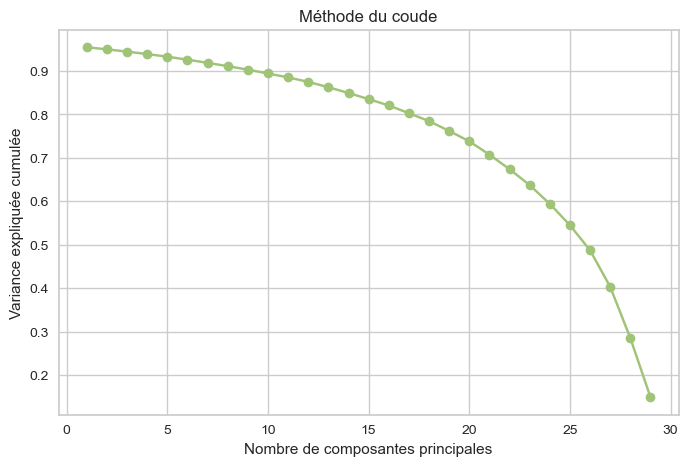

In [217]:
inertie = pca.explained_variance_ratio_

# Variance expliquée cumulée
inertie_cum = np.cumsum(inertie)
inertie_cum = np.sort(inertie_cum)[::-1]

# Tracé de la courbe
k_inertie = range(1, len(inertie_cum) + 1)
plt.figure(figsize=(8, 5))
plt.plot(k_inertie, inertie_cum, 'go-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Méthode du coude')
plt.grid(True)
plt.show()

Les hyperparamètres utilisés sont : 
- 

In [218]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means(kmeans, name=init, data=X_pca, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.079s	1181	0.230	0.856	0.362	0.138	0.120
k-means++	0.369s	1126	0.306	0.645	0.415	0.226	0.129
k-means++	0.172s	1084	0.387	0.690	0.496	0.284	0.135
k-means++	0.190s	1043	0.483	0.728	0.581	0.378	0.147
k-means++	0.161s	1008	0.531	0.721	0.611	0.415	0.158
k-means++	0.282s	975	0.619	0.770	0.687	0.501	0.172
k-means++	0.213s	950	0.696	0.790	0.740	0.618	0.185
k-means++	0.367s	924	0.719	0.774	0.746	0.637	0.201
k-means++	0.223s	903	0.773	0.781	0.777	0.715	0.191
k-means++	0.221s	887	0.746	0.731	0.739	0.642	0.183
k-means++	0.408s	866	0.781	0.732	0.756	0.676	0.195
k-means++	0.490s	850	0.800	0.729	0.763	0.680	0.174
k-means++	0.383s	840	0.806	0.719	0.760	0.681	0.172
k-means++	0.073s	1181	0.230	0.856	0.362	0.138	0.123
k-means++	0.139s	1126	0.306	0.645	0.415	0.226	0.132
k-means++	0.086s	1084	0.387	0.690	0.496	0.284	0.119
k-means++	0.135s	1043	0.483	0.728	0.581	0

In [219]:
best_param_grid = best_params
print(best_param_grid)

{'n_clusters': 11, 'init': 'k-means++', 'n_init': 20, 'max_iter': 300}


### Scaling

#### Without scaling

In [220]:
def bench_k_means_simple(kmeans, name, data, labels):

    t0 = time()
    estimator = make_pipeline(kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=500,
        )
    ]
    

    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))
    return results

In [221]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=11, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means_simple(kmeans, name=init, data=X_pca, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params_simple = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params_simple)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.160s	1036272	0.789	0.763	0.776	0.728	0.189
k-means++	0.155s	1036272	0.789	0.763	0.776	0.728	0.192
k-means++	0.136s	1036272	0.789	0.763	0.776	0.728	0.197
k-means++	0.134s	1036272	0.789	0.763	0.776	0.728	0.202
k-means++	0.129s	1036272	0.789	0.763	0.776	0.728	0.202
k-means++	0.130s	1036272	0.789	0.763	0.776	0.728	0.195
k-means++	0.117s	1036272	0.789	0.763	0.776	0.728	0.185
k-means++	0.125s	1036272	0.789	0.763	0.776	0.728	0.193
k-means++	0.123s	1036272	0.789	0.763	0.776	0.728	0.196
k-means++	0.118s	1036272	0.789	0.763	0.776	0.728	0.195
k-means++	0.112s	1036272	0.789	0.763	0.776	0.728	0.197
k-means++	0.130s	1036272	0.789	0.763	0.776	0.728	0.197
k-means++	0.135s	1036272	0.789	0.763	0.776	0.728	0.200
k-means++	0.120s	1036272	0.789	0.763	0.776	0.728	0.192
k-means++	0.132s	1036272	0.789	0.763	0.776	0.728	0.195
k-means++	0.112s	1036272	0.789	0.763	0.7

In [222]:
best_param_grid_simple = best_params_simple
print(best_param_grid_simple)

{'init': 'random', 'n_init': 20, 'max_iter': 300}


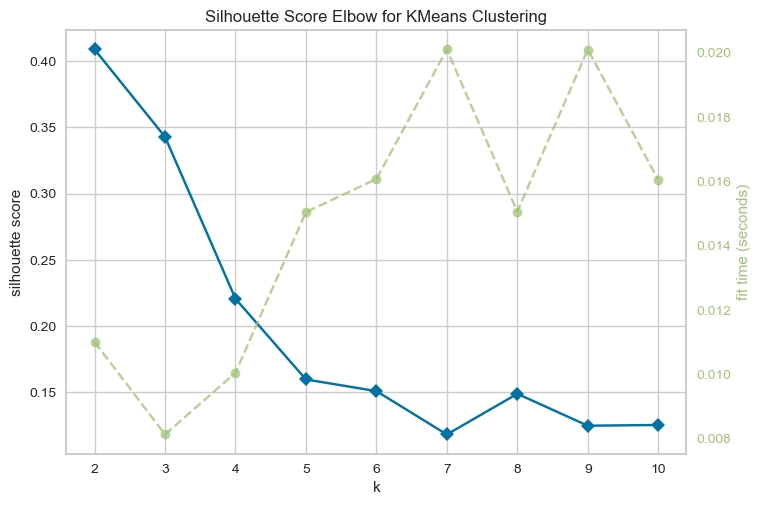

In [223]:
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              # k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

#### MinMaxScaler

In [235]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [236]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means_simple(kmeans, name=init, data=X_scaled, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params_simple = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params_simple)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.121s	7596	0.232	0.860	0.366	0.139	0.126
k-means++	0.120s	6877	0.313	0.661	0.425	0.237	0.126
k-means++	0.083s	6405	0.366	0.611	0.458	0.288	0.127
k-means++	0.108s	5976	0.460	0.701	0.555	0.349	0.143
k-means++	0.141s	5597	0.522	0.693	0.595	0.430	0.154
k-means++	0.234s	5324	0.573	0.700	0.630	0.478	0.171
k-means++	0.122s	5039	0.673	0.770	0.719	0.581	0.180
k-means++	0.153s	4793	0.693	0.752	0.721	0.598	0.186
k-means++	0.127s	4648	0.740	0.750	0.745	0.665	0.182
k-means++	0.142s	4520	0.746	0.729	0.738	0.648	0.180
k-means++	0.172s	4402	0.804	0.756	0.779	0.733	0.175
k-means++	0.204s	4274	0.816	0.743	0.778	0.712	0.184
k-means++	0.201s	4180	0.812	0.720	0.763	0.672	0.185
k-means++	0.068s	7596	0.232	0.860	0.366	0.139	0.130
k-means++	0.061s	6877	0.313	0.661	0.425	0.237	0.132
k-means++	0.092s	6405	0.366	0.611	0.458	0.288	0.125
k-means++	0.082s	5976	0.460	0.701

In [226]:
best_params_minmax = best_params_simple
print(best_params_minmax)

{'init': 'k-means++', 'n_init': 20, 'max_iter': 300}


#### StandardScaler

In [227]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [228]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means_simple(kmeans, name=init, data=X_scaled, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params_simple = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params_simple)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.085s	100424	0.185	0.644	0.288	0.127	0.110
k-means++	0.071s	93842	0.297	0.628	0.403	0.223	0.112
k-means++	0.089s	89214	0.372	0.626	0.466	0.297	0.095
k-means++	0.112s	85096	0.378	0.609	0.467	0.294	0.103
k-means++	0.135s	81678	0.476	0.642	0.547	0.359	0.101
k-means++	0.087s	77749	0.486	0.628	0.548	0.382	0.100
k-means++	0.161s	74854	0.581	0.697	0.634	0.469	0.115
k-means++	0.195s	72030	0.583	0.660	0.619	0.462	0.158
k-means++	0.190s	69814	0.650	0.694	0.671	0.534	0.124
k-means++	0.230s	67262	0.674	0.692	0.683	0.542	0.145
k-means++	0.194s	65032	0.673	0.684	0.679	0.551	0.149
k-means++	0.185s	62763	0.673	0.683	0.678	0.551	0.156
k-means++	0.189s	61963	0.692	0.686	0.689	0.567	0.150
k-means++	0.080s	100424	0.185	0.644	0.288	0.127	0.117
k-means++	0.084s	93842	0.297	0.628	0.403	0.223	0.100
k-means++	0.090s	89214	0.372	0.626	0.466	0.297	0.104
k-means++	0.122

In [229]:
best_params_standard = best_params_simple
print(best_params_standard)

{'init': 'random', 'n_init': 10, 'max_iter': 300}


#### Robust Scaler

In [230]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [232]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means_simple(kmeans, name=init, data=X_scaled, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params_simple = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params_simple)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.110s	68374	0.042	0.288	0.074	0.011	0.418
k-means++	0.159s	59272	0.074	0.280	0.117	0.017	0.372
k-means++	0.160s	54480	0.180	0.403	0.249	0.097	0.144
k-means++	0.165s	50439	0.237	0.413	0.301	0.141	0.155
k-means++	0.193s	47106	0.213	0.337	0.261	0.109	0.141
k-means++	0.205s	44252	0.258	0.365	0.302	0.148	0.154
k-means++	0.269s	42395	0.268	0.367	0.310	0.151	0.142
k-means++	0.276s	40746	0.314	0.395	0.350	0.166	0.136
k-means++	0.271s	39073	0.356	0.399	0.376	0.224	0.134
k-means++	0.172s	37502	0.381	0.411	0.395	0.237	0.122
k-means++	0.174s	36309	0.435	0.446	0.440	0.293	0.141
k-means++	0.236s	35455	0.454	0.454	0.454	0.287	0.139
k-means++	0.226s	34528	0.460	0.440	0.450	0.298	0.142
k-means++	0.065s	68374	0.042	0.288	0.074	0.011	0.408
k-means++	0.111s	59272	0.074	0.280	0.117	0.017	0.363
k-means++	0.127s	54480	0.180	0.403	0.249	0.097	0.148
k-means++	0.121s	

In [200]:
best_params_standard = best_params_simple
print(best_params_standard)

{'init': 'random', 'n_init': 10, 'max_iter': 300}


## Profiling: cluster persona


In [237]:
reduced_data = PCA(n_components=2).fit_transform(X)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

kmeans_final = KMeans(n_clusters=11, 
                      init='k-means++', 
                      max_iter=300, 
                      n_init=20, 
                      random_state=42)

kmeans_final.fit(reduced_data)

kmean_labels = kmeans.labels_

In [238]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,12
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,3
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,11
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,8
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,5


In [141]:
persona_summary = data.groupby('cluster').mean()
# print(persona_summary)

In [132]:
# Chiffre correspondant à chaque cluster
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0     7
1     4
2     2
3     8
4     6
5     8
6     3
7     7
8     5
9     1
10    1
11    7
12    0
13    2
dtype: int32


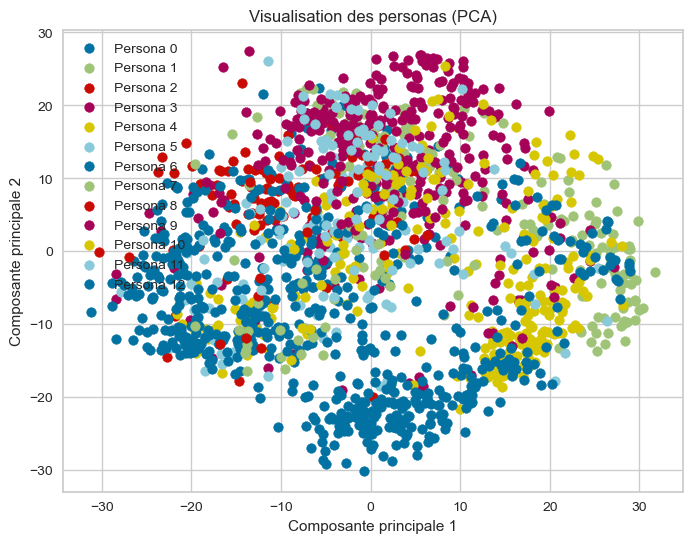

In [145]:
data['pca1'] = X_pca[:, 0]
data['pca2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
for cluster in range(13):
    plt.scatter(data[data['cluster'] == cluster]['pca1'],
                data[data['cluster'] == cluster]['pca2'],
                label=f'Persona {cluster}')
plt.legend()
plt.title("Visualisation des personas (PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

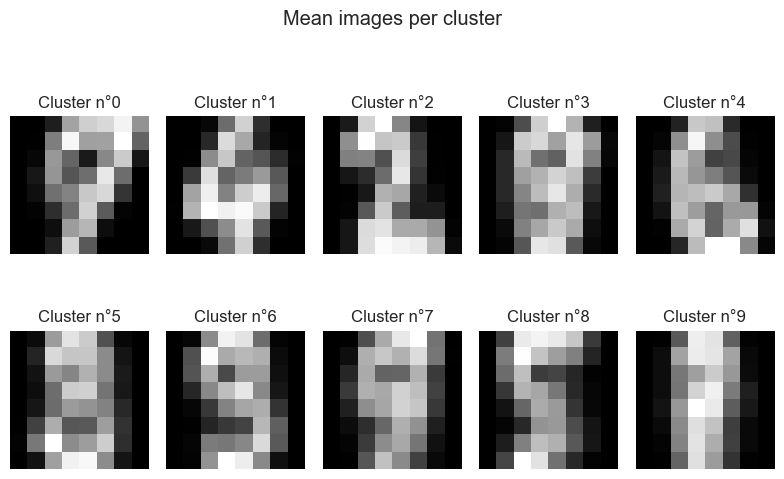

In [146]:
# Image sur les centroides (image moyen)
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

# SOLUTION : Tuning des hyperparametres

### Visualization

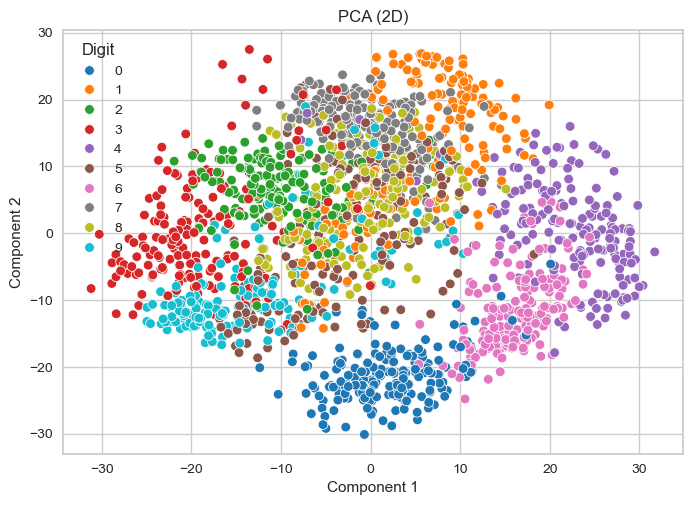

In [147]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()

In [148]:
# Permet de voir 

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

ValueError: X has 2 features, but KMeans is expecting 64 features as input.

## Intercluster Distance Maps

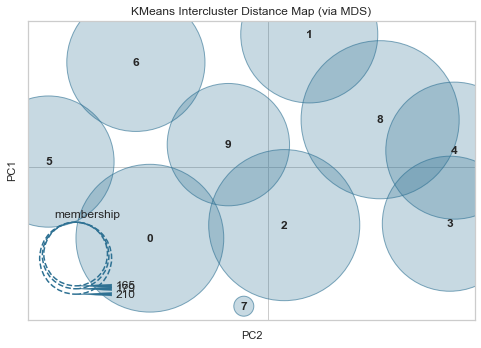

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [23]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [240]:
from sklearn.manifold import TSNE

In [241]:
# Initialize

tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric='euclidean')
X_tsne = tsne.fit_transform(X_scaled)

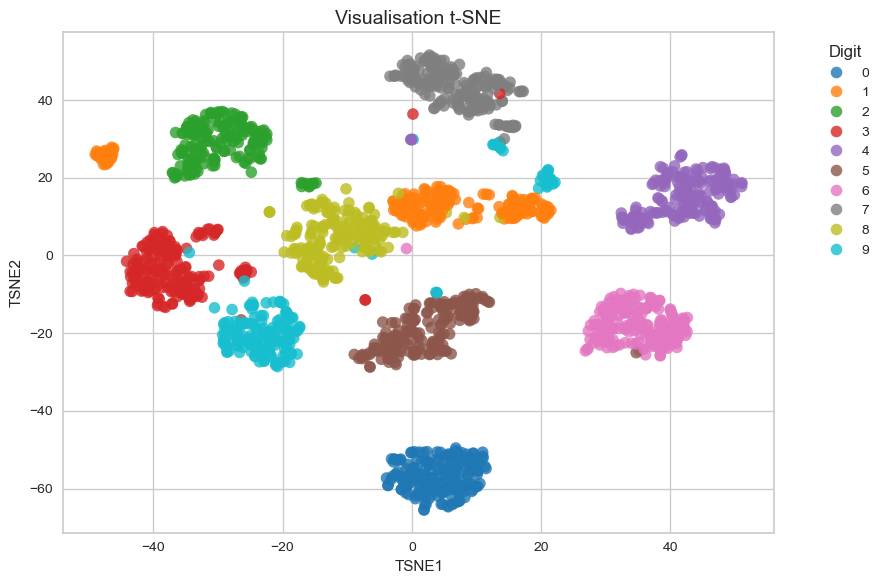

In [242]:
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = labels # Conversion en string pour une discrétisation catégorielle

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation t-SNE', fontsize=14)
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()